In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


## Prepare Dataset

In [2]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

train_dataset_path = './dataset/train_preprocess_no_stemming.csv'
valid_dataset_path = './dataset/valid_preprocess_no_stemming.csv'

In [3]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)

train_df.columns = ['label', 'tweet_tokens_no_stemming']
valid_df.columns = ['label', 'tweet_tokens_no_stemming']

In [4]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'dimiliki', 'pengusaha', 'pabrik', ..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,negative,"['duh', 'mahasiswa', 'jangan-jangan', 'sombong..."
5,positive,"['makanan', 'beragam', 'harga', 'makanan', 'fo..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak', ..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makanan', 'ena..."
8,positive,"['keluarga', 'menikmati', 'pengalaman', 'kulin..."
9,positive,['bersyukur']


In [5]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'dimiliki', 'pengusaha', 'pabrik', ..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,negative,"['duh', 'mahasiswa', 'jangan-jangan', 'sombong..."
5,positive,"['makanan', 'beragam', 'harga', 'makanan', 'fo..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak', ..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makanan', 'ena..."
8,positive,"['keluarga', 'menikmati', 'pengalaman', 'kulin..."
9,positive,['bersyukur']


In [6]:
def get_label_idx(label):
    if label == 'positive':
        return 2
    if label == 'negative':
        return 1
    if label == 'neutral':
        return 0
train_df['label'] = train_df['label'].apply(get_label_idx)
valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [7]:
train_df

,label,tweet_tokens_no_stemming
0,2,"['warung', 'dimiliki', 'pengusaha', 'pabrik', ..."
1,0,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,2,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,2,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,1,"['duh', 'mahasiswa', 'jangan-jangan', 'sombong..."
...,...,...
10996,2,"['enak', 'masakan', 'kepiting', 'menyenangkan'..."
10997,0,"['hormati', 'partaipartai', 'berkoalisi']"
10998,1,"['pagi', 'pagi', 'tol', 'pasteur', 'macet', 'p..."
10999,2,"['belanja', 'yogya', 'riau', 'junction', 'kali..."


In [8]:
jumlah_positives = (train_df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (train_df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 6417
Jumlah review negatif: 3436


In [9]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet_tokens_no_stemming"].apply(join_text_list)
valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

0    warung dimiliki pengusaha pabrik puluhan tahun...
1    mohon ulama lurus mmbri hujjah partai apa-apa ...
2    lokasi strategis jalan sumatera bandung nyaman...
3    betapa bahagia unboxing paket barang bagus men...
4    duh mahasiswa jangan-jangan sombong kasih kart...
Name: preprocessed, dtype: object

In [10]:
# Filter DataFrame untuk label 1 dan 2
df_train_filtered = train_df[train_df['label'].isin([1, 2])]
df_valid_filtered = valid_df[valid_df['label'].isin([1, 2])]

# Perbarui label sehingga label 1 menjadi 0 dan label 2 menjadi 1
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map({1: 0, 2: 1})
df_valid_filtered.loc[:, 'label'] = df_valid_filtered['label'].map({1: 0, 2: 1})


# Split dataset menjadi fitur (X) dan label (y)
X_train = df_train_filtered['preprocessed']
y_train = df_train_filtered['label']

X_valid = df_valid_filtered['preprocessed']
y_valid = df_valid_filtered['label']

In [11]:
## hitung jumlah positive dan negative
jumlah_positives = (y_train == 1).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_train == 0).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

jumlah_positives = (y_valid == 1).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_valid == 0).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 6417
Jumlah review negatif: 3436
Jumlah review positif: 735
Jumlah review negatif: 394


## Generate Padded Sequence

In [12]:
# Parameters

vocab_size = 20000 #ukuran kosakata yang akan digunakan
max_length = 100 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [13]:
## Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)


all_texts = list(X_train) + list(X_valid)

# Generate word index dictionary for the training sentences
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
print(word_index)

# Convert the training sentences into word sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# Convert the validation sentences into word sequences
valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)

{'<OOV>': 1, 'tidak': 2, 'makanan': 3, 'enak': 4, 'makan': 5, 'harga': 6, 'bandung': 7, 'menu': 8, 'banget': 9, 'orang': 10, 'restoran': 11, 'suasana': 12, 'nyaman': 13, 'malam': 14, 'besar': 15, 'ayam': 16, 'pelayanan': 17, 'goreng': 18, 'nasi': 19, 'bagus': 20, 'pemandangan': 21, 'jalan': 22, 'suka': 23, 'mahal': 24, 'jangan': 25, 'lumayan': 26, 'apa': 27, 'anak': 28, 'pilihan': 29, 'cocok': 30, 'keluarga': 31, 'kecil': 32, 'lokasi': 33, 'resto': 34, 'kota': 35, 'pas': 36, 'porsi': 37, 'tahun': 38, 'salah': 39, 'steak': 40, 'pesan': 41, 'sunda': 42, 'deh': 43, 'minuman': 44, 'khas': 45, 'masakan': 46, 'kafe': 47, 'kali': 48, 'murah': 49, 'teman': 50, 'mi': 51, 'rumah': 52, 'indonesia': 53, 'dingin': 54, 'favorit': 55, 'menikmati': 56, 'oke': 57, 'bakso': 58, 'ramai': 59, 'mantap': 60, 'ramah': 61, 'terjangkau': 62, 'mencoba': 63, 'nama': 64, 'sambal': 65, 'daging': 66, 'bakar': 67, 'coba': 68, 'jam': 69, 'siang': 70, 'luas': 71, 'masuk': 72, 'batagor': 73, 'cepat': 74, 'memesan': 75,

In [36]:
# import pickle

# Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
print(train_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  128 1921 3780 3305 1182   38
   38  129  372    7  519 1314 7903 1256 1314 7904  128  181    8  262
 1922  137    8   16  203   53    6   62   25   25 2642 7905    2  313
  268 7906]


## Word Embedding

In [15]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [16]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [17]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.23877668,  0.05460626, -1.104177  , ..., -0.02637626,
         2.63988543,  0.1278699 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [18]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[101])
print(word)

('meja', array([-2.85646534, -1.79651177,  0.28729838, -0.2869671 ,  0.26857349,
       -1.13205981,  2.0555594 , -0.84380871]))


## Build and Compile Model

In [28]:



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    # tf.keras.layers.Embedding(vocab_size, 8, input_shape=(max_length,)),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
    # tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 8)            │    160,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 128)          │      5,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 16)                │    102,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 267,681 (1.02 MB)

 Trainable params: 267,681 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_17
Weights Shape (Tensor 0): (20000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.3466582  -0.17813095 -0.6445226  ... -0.044117    2.5439978
  -0.34757566]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: conv1d_19
Weights Shape (Tensor 0): (5, 8, 128)
Weights (Tensor 0):
[[[ 1.82889476e-02  7.49402046e-02  2.09810659e-02 ...  2.90696323e-03
   -6.99859932e-02  6.17698133e-02]
  [ 1.38147697e-02 -4.03712504e-02 -5.93437962e-02 ... -4.76750135e-02
    9.29504633e-04 -4.15945165e-02]
  [ 8.36187154e-02 -4.17046249e-04  8.55019987e-02 ... -1.59613118e-02
    4.25610989e-02 -7.35746324e-02]
  ...
  [-7.79846460e-02  6.76908940e-02  4.34990376e-02 ... -4.14

## Train Model

In [20]:
num_epochs = 6

history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(valid_padded, y_valid), verbose=2)


Epoch 1/6
308/308 - 7s - 23ms/step - accuracy: 0.8233 - loss: 0.4343 - val_accuracy: 0.8601 - val_loss: 0.3587
Epoch 2/6
308/308 - 4s - 14ms/step - accuracy: 0.8563 - loss: 0.3716 - val_accuracy: 0.8751 - val_loss: 0.3231
Epoch 3/6
308/308 - 3s - 9ms/step - accuracy: 0.8723 - loss: 0.3348 - val_accuracy: 0.8884 - val_loss: 0.2803
Epoch 4/6
308/308 - 3s - 9ms/step - accuracy: 0.8904 - loss: 0.2737 - val_accuracy: 0.9017 - val_loss: 0.2506
Epoch 5/6
308/308 - 3s - 9ms/step - accuracy: 0.9156 - loss: 0.2101 - val_accuracy: 0.9132 - val_loss: 0.2553
Epoch 6/6
308/308 - 3s - 9ms/step - accuracy: 0.9364 - loss: 0.1630 - val_accuracy: 0.9141 - val_loss: 0.2465


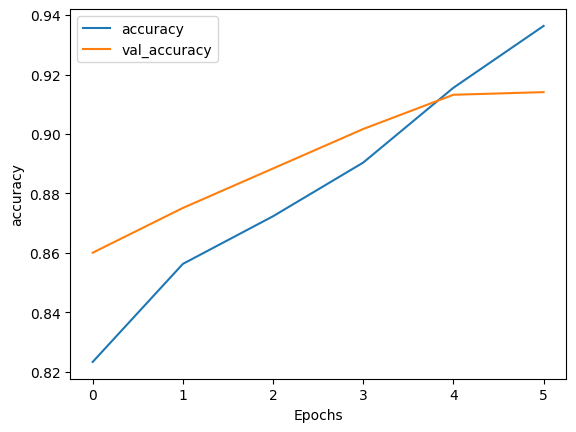

In [21]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

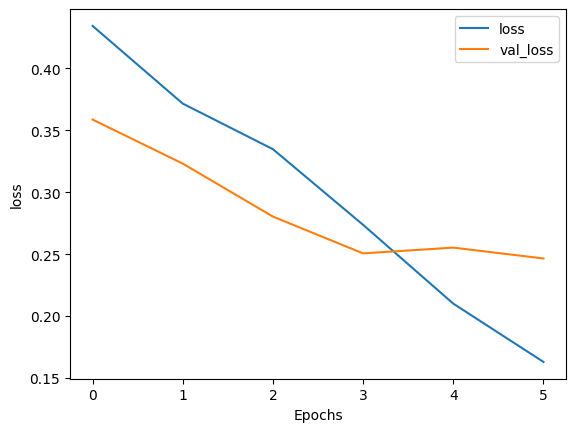

In [22]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [30]:
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type)
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Menggunakan fungsi untuk memprediksi sentimen dari contoh kalimat
sample_text = "Saya tidak masalah sama sekali gaji dipotong tiap bulan untuk BPJS Kesehatan. Semisal jarang pakai pun, anggap saja sedekah dan membantu sesama.  Tapi untuk TAPERA ini, jelas saya tidak ikhlas. Subsidi silang buat yang tidak mampu? Ah tidak juga rasanya.  Kebijakan aneh."
predicted_label = predict_sentiment(model, tokenizer, sample_text)
print("Label Sentimen:", predicted_label)
   


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[0.50306106]]
Label Sentimen: Positif


In [31]:
# Asumsi model dan tokenizer sudah didefinisikan
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type)
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Kalimat contoh untuk pengujian
test_sentences = [
    "Pada awalnya saya ragu dengan kemampuan perusahaan ini, namun setelah melihat kinerja mereka selama beberapa bulan terakhir, saya sangat puas dengan hasil yang mereka capai.",
    "Film ini memulai dengan sangat membosankan dan lambat, tetapi akhir ceritanya sangat mengharukan dan membuat saya terkesan.",
    "Meskipun layanan pelanggan mereka sangat lambat dan kurang responsif, kualitas produk yang mereka tawarkan sangatlah bagus.",
    "Restoran ini memiliki makanan yang lezat, tetapi pelayanannya sangat buruk dan membuat pengalaman makan saya tidak menyenangkan.",
    "Saya mengalami banyak masalah dengan perangkat ini di awal, namun setelah pembaruan terbaru, kinerjanya menjadi jauh lebih baik.",
    "Aplikasi ini sering mengalami crash pada versi awal, tetapi sekarang setelah beberapa pembaruan, aplikasinya sangat stabil dan berguna.",
    "Hotel ini memiliki pemandangan yang luar biasa dan staf yang ramah, meskipun kamarnya cukup kotor pada saat saya tiba.",
    "Buku ini dimulai dengan alur yang sangat lambat, namun karakter dan ceritanya berkembang dengan sangat baik menjelang akhir.",
    "Konser ini awalnya terasa membosankan, tetapi penampilan penutupnya sangat spektakuler dan membuat semuanya terbayar.",
    "Saya awalnya kecewa dengan kualitas pakaian ini, tetapi setelah beberapa kali dicuci, kualitas bahannya ternyata sangat tahan lama.",
    "Saya tidak masalah sama sekali gaji dipotong tiap bulan untuk BPJS Kesehatan. Semisal jarang pakai pun, anggap saja sedekah dan membantu sesama.  Tapi untuk TAPERA ini, jelas saya tidak ikhlas. Subsidi silang buat yang tidak mampu? Ah tidak juga rasanya.  Kebijakan aneh.",
    "Kebijakan pemerintah tentang kenaikan harga BBM sangat memberatkan masyarakat kecil.",
    "Reformasi pajak yang diusulkan akan sangat membantu meningkatkan perekonomian negara.",
    "Keputusan untuk memperpanjang masa jabatan presiden sangat kontroversial dan memicu banyak protes.",
    "Program bantuan sosial yang baru diluncurkan sangat membantu masyarakat miskin.",
    "Pemilihan umum kali ini sangat penting untuk masa depan negara kita.",
    "Banyak yang kecewa dengan hasil debat politik semalam, banyak janji yang tidak realistis.",
    "Tindakan korupsi yang dilakukan oleh pejabat tinggi harus ditindak tegas.",
    "Perubahan undang-undang ini sangat penting untuk melindungi hak-hak pekerja.",
    "Diskusi tentang kebijakan luar negeri semakin memanas, banyak pihak yang berbeda pendapat.",
    "Partai oposisi mengkritik keras kebijakan ekonomi pemerintah yang dianggap tidak efektif.",
    "Rencana pembangunan infrastruktur baru di wilayah timur sangat disambut baik oleh masyarakat."
]


# Memprediksi sentimen untuk setiap kalimat
for sentence in test_sentences:
    predicted_label = predict_sentiment(model, tokenizer, sentence)
    print(f"Teks: {sentence}\nLabel Sentimen: {predicted_label}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
[[0.47391334]]
Teks: Pada awalnya saya ragu dengan kemampuan perusahaan ini, namun setelah melihat kinerja mereka selama beberapa bulan terakhir, saya sangat puas dengan hasil yang mereka capai.
Label Sentimen: Negatif

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
[[0.5043305]]
Teks: Film ini memulai dengan sangat membosankan dan lambat, tetapi akhir ceritanya sangat mengharukan dan membuat saya terkesan.
Label Sentimen: Positif

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[[0.4972167]]
Teks: Meskipun layanan pelanggan mereka sangat lambat dan kurang responsif, kualitas produk yang mereka tawarkan sangatlah bagus.
Label Sentimen: Negatif

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[[0.48996255]]
Teks: Restoran ini memiliki makanan yang lezat, tetapi pelayanannya sangat buruk dan membuat pengalaman makan saya tidak menyenangkan.
Label Sentimen: Negatif

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[[0.4992841]]
Teks: Saya mengalami banyak masalah dengan perangkat ini d

In [24]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = (y_pred >= 0.5).astype(int)

# Mencetak classification report
print(classification_report(df_valid_filtered["label"], y_pred_classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       394
           1       0.96      0.90      0.93       735

    accuracy                           0.91      1129
   macro avg       0.90      0.92      0.91      1129
weighted avg       0.92      0.91      0.92      1129



In [113]:
#save model
# model.save('./model/model-cnn-word2vec-2-classes-no-stemming.h5')

In [115]:
import numpy as np
import tensorflow as tf

# Inisialisasi bobot kernel dengan ukuran 5
kernel_size = 5
num_filters = 1
embedding_dim = 8

# Membuat bobot kernel dengan inisialisasi Glorot uniform
initializer = tf.keras.initializers.GlorotUniform()
kernel_weights = initializer(shape=(kernel_size, embedding_dim, num_filters))

# Dibulatkan ke angka terdekat
kernel_weights_rounded = np.round(kernel_weights, decimals=2)

print("Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):")
print(kernel_weights_rounded)
print("Shape bobot kernel:", kernel_weights.shape)


Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):
[[[-0.09]
  [ 0.12]
  [-0.29]
  [-0.14]
  [ 0.17]
  [-0.1 ]
  [-0.02]
  [-0.33]]

 [[ 0.34]
  [ 0.17]
  [-0.32]
  [-0.18]
  [ 0.19]
  [-0.18]
  [-0.04]
  [ 0.01]]

 [[-0.19]
  [-0.3 ]
  [ 0.35]
  [ 0.3 ]
  [-0.33]
  [ 0.03]
  [-0.25]
  [-0.21]]

 [[ 0.12]
  [-0.13]
  [-0.33]
  [-0.2 ]
  [-0.2 ]
  [ 0.25]
  [-0.35]
  [ 0.33]]

 [[-0.24]
  [-0.36]
  [ 0.07]
  [ 0.01]
  [-0.14]
  [-0.25]
  [ 0.1 ]
  [-0.04]]]
Shape bobot kernel: (5, 8, 1)
